# Ejercicio 8

In [1]:
import time
import random
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

In [2]:
STEPS = 5000
RANGE = 250
LONG_CELDA_EN_M = 0.4
CELDAS_DE_DISTANCIA = 5
PROBABILIDAD_DE_CONTAGIO = 0.65
PROBABILIDAD_CONTAGIO_CON_MEDIDAS = 0.15
PROBABILIDAD_INICIA_CONTAGIADO = 0.3

In [3]:
class Persona:
    q_persona = 0
    
    def __init__(self, x_init, y_init, tablero, contagiado, puede_moverse, α, β, n_contagios, verbose=False):
        self.numero = Persona.q_persona
        Persona.q_persona += 1
        self.tablero = tablero
        self.contagiado = contagiado
        self.steps_enfermo = 0
        self.puede_moverse = puede_moverse
        self.x = x_init
        self.y = y_init
        self.verbose = verbose
        self.α = α
        self.β = β
        self.n_contagios = n_contagios
        self.fue_infectado = contagiado
        
        
    def get_position(self):
        return self.x, self.y
    
    def esta_contagiado(self):
        return self.contagiado
        
    def step(self):
        if self.puede_moverse:
            return self.step_normal()
        else:
            return self.x, self.y
    
    def propagar_contagios(self, n_step):
        if self.contagiado:
            self.steps_enfermo += 1
            if self.steps_enfermo >= self.α:
                if (np.random.rand() <= self.β):
                    self.contagiado = False
                    self.steps_enfermo = 0
        elif self.n_contagios | (not self.fue_infectado):
            self.contagiado = self.tablero.propagar_contagios_por_cercania(self.x,
                                            self.y, CELDAS_DE_DISTANCIA, n_step)
            if self.contagiado:
                self.fue_infectado = True
            
        
class Tablero:
    """
        α: tiempo de recuperacion
        B: probabilidad de sanar después del tiempo de recuperacion
    """
    def __init__(self, n_dim, n_personas, tasa_contagio_inicial, λ, α, β, n_contagios, T=False, verbose=False):
        self.verbose = verbose
        self.dim = n_dim
        self.personas = self.__init_personas(n_personas, n_contagios, λ, α, β)
        self.tasa_contagio = tasa_contagio_inicial
        self.T = T
        self.personas_contagiadas = []
    
    def __init_personas(self, n_personas, n_contagios, λ, α, β):
        def get_init_positions(n_persons):
            indexes = [(i, j) for i in range(0, self.dim) for j in range(0, self.dim)]
            random.shuffle(indexes)
            return indexes[:n_persons]
        
        def generate_persons(pos, n_contagios, λ, α, β):
            persons = []
            n = np.random.rand(len(pos))
            s = np.random.rand(len(pos))
            m = np.random.rand(len(pos))
            for (x_init, y_init), ni, si, mi in zip(pos, n, s, m):
                contagiado = (si <= PROBABILIDAD_INICIA_CONTAGIADO)
                puede_moverse = (mi <= λ)
                if ni <= 0.1:
                    persons.append(PersonaC(x_init, y_init, self, contagiado, puede_moverse,
                                            α, β, n_contagios, self.verbose))
                elif ni > 0.1 and ni <= 0.3:
                    persons.append(PersonaB(x_init, y_init, self, contagiado, puede_moverse,
                                            α, β, n_contagios, self.verbose))
                else:
                    persons.append(PersonaA(x_init, y_init, self, contagiado, puede_moverse,
                                            α, β, n_contagios, self.verbose))
            return persons
        
        init_positions = get_init_positions(n_personas)
        return generate_persons(init_positions, n_contagios, λ, α, β)
        
    def get_movimientos_posibles(self, x, y):
        movs = [(x+1, y), (x-1, y), (x, y+1), (x, y-1)]
        movs = list(filter(lambda x: x[0] > 0 and x[0] <= self.dim and x[1] > 0 and x[1] <= self.dim, movs))
        actual_positions = [p.get_position() for p in self.personas]
        possible_movs = set(movs) - set(actual_positions)
        return list(possible_movs)
    
    def propagar_contagios_por_cercania(self, x, y, distancia_limite, n_step):
        def cantidad_contagiados_suficientemente_cerca(x, y, actual_contagiados, distancia_limite):
            contador = 0
            for c in actual_contagiados:
                distancia_en_x = abs(c[0] - x)
                distancia_en_y = abs(c[1] - y)
                if (distancia_en_x + distancia_en_y) < 5:
                    contador += 1
            return contador
        
        actual_contagiados = [p.get_position() for p in self.personas if p.esta_contagiado()]

        contador = cantidad_contagiados_suficientemente_cerca(x, y, actual_contagiados, distancia_limite)
        p_contagios = [p <= self.get_probabilidad_de_contagios(n_step) for p in np.random.rand(contador)]
        return any(p_contagios)
            
    def siguiente_ronda(self, n_step):
        cantidad_contagios = 0
        for p in self.personas:
            p.step()
            p.propagar_contagios(n_step)
            if p.esta_contagiado(): cantidad_contagios += 1
        self.personas_contagiadas.append(cantidad_contagios)
        return self.personas
    
    def get_probabilidad_de_contagios(self, n_step):
        if self.T is not None and n_step >= self.T:
            return PROBABILIDAD_CONTAGIO_CON_MEDIDAS
        else:
            return self.tasa_contagio
    
    def get_personas_contagiadas(self):
        return self.personas_contagiadas

In [4]:
class PersonaC(Persona):
    def __init__(self, x_inicial, y_inicial, tablero, contagiado, puede_moverse, α, β, n_contagios, verbose=False):
        super().__init__(x_inicial, y_inicial, tablero, contagiado, puede_moverse, α, β, n_contagios, verbose)
        self.tipo = 'C'
#         self.hex_color = '#49111C' # bordó
        self.hex_color = '#3d405b' # violeta
        self.contador = 0
            
    def step_normal(self):
        self.contador += 1
        if self.contador == 4:
            self.contador = 0
            movimientos = self.tablero.get_movimientos_posibles(self.x, self.y)
            if len(movimientos) > 0:
                idx = np.argmax(np.random.uniform(0, LONG_CELDA_EN_M, len(movimientos)))
                self.x, self.y = movimientos[idx]
                if self.verbose:
                    print("({}) Posicion x: {}".format(self.numero, self.x))
                    print("({}) Posicion y: {}".format(self.numero, self.y))
        return self.x, self.y

    
class PersonaB(Persona):
    def __init__(self, x_inicial, y_inicial, tablero, contagiado, puede_moverse, α, β, n_contagios, verbose=False):
        super().__init__(x_inicial, y_inicial, tablero, contagiado, puede_moverse, α, β, n_contagios, verbose)
        self.tipo = 'B'
#         self.hex_color = '#FF5A5F' # naranja1
        self.hex_color = '#e07a5f' # naranja2
        self.contador = 0
    
    def step_normal(self):
        self.contador += 1
        if self.contador == 2:
            self.contador = 0
            movimientos = self.tablero.get_movimientos_posibles(self.x, self.y)
            if len(movimientos) > 0:
                idx = np.argmax(np.random.uniform(0, LONG_CELDA_EN_M, len(movimientos)))
                self.x, self.y = movimientos[idx]
                if self.verbose:
                    print("({}) Posicion x: {}".format(self.numero, self.x))
                    print("({}) Posicion y: {}".format(self.numero, self.y))
        return self.x, self.y
    
class PersonaA(Persona):
    def __init__(self, x_inicial, y_inicial, tablero, contagiado, puede_moverse, α, β, n_contagios, verbose=False):
        super().__init__(x_inicial, y_inicial, tablero, contagiado, puede_moverse, α, β, n_contagios, verbose)
        self.tipo = 'A'
#         self.hex_color = '#087E8B' # celeste
        self.hex_color = '#81b29a' # verde

    def step_normal(self):
        movimientos = self.tablero.get_movimientos_posibles(self.x, self.y)
        if len(movimientos) > 0:
            idx = np.argmax(np.random.uniform(0, LONG_CELDA_EN_M, len(movimientos)))
            self.x, self.y = movimientos[idx]
            if self.verbose:
                print("({}) Posicion x: {}".format(self.numero, self.x))
                print("({}) Posicion y: {}".format(self.numero, self.y))
        return self.x, self.y

In [5]:
colores_por_enfermedad = {True: '#ef233c', False: '#8ecae6'}

def animate_persons(n_step, tablero, lines, por_enfermedad=False):
    new_lines = []
    persons = tablero.siguiente_ronda(n_step)
    for person, line in zip(persons, lines):
        x, y = person.get_position()
        line.set_data([x*LONG_CELDA_EN_M], [y*LONG_CELDA_EN_M])
        if not por_enfermedad:
            line.set_color(person.hex_color)
        else:
            line.set_color(colores_por_enfermedad[person.esta_contagiado()])
        new_lines.append(line)
    return new_lines

In [6]:
def gen_lines(ax, n_personas):
#     cmap = plt.cm.get_cmap('hsv', n_personas)
    lines = [ax.plot([], [], marker='o', markersize=9)[0] for n in range(n_personas)]
    return lines

# Set up tablero

In [7]:
set_de_parametros = [
    # simulacion 1
    {'N_PERSONAS': 1000, 'α': 250, 'β': 0.5, 'T': 2500, 'λ': 0.8, 'N_CONTAGIOS': True},
    # simulacion 2
    {'N_PERSONAS': 1000, 'α': 250, 'β': 0.5, 'T': 750, 'λ': 0.8, 'N_CONTAGIOS': False},
    # simulacion 3
    {'N_PERSONAS': 1000, 'α': 300, 'β': 0.7, 'T': 500, 'λ': 0.2, 'N_CONTAGIOS': True},
]

In [8]:
# N_PERSONAS = 100
# α = 20 #STEPS/20
# β = 0.5
# T = STEPS*0.4
# λ = 0.8
# tablero = Tablero(RANGE, N_PERSONAS, PROBABILIDAD_DE_CONTAGIO, λ, α, β, N_CONTAGIOS, T)

Vamos con el set de parametros {'N_PERSONAS': 1000, 'α': 300, 'β': 0.7, 'T': 500, 'λ': 0.2, 'N_CONTAGIOS': True}


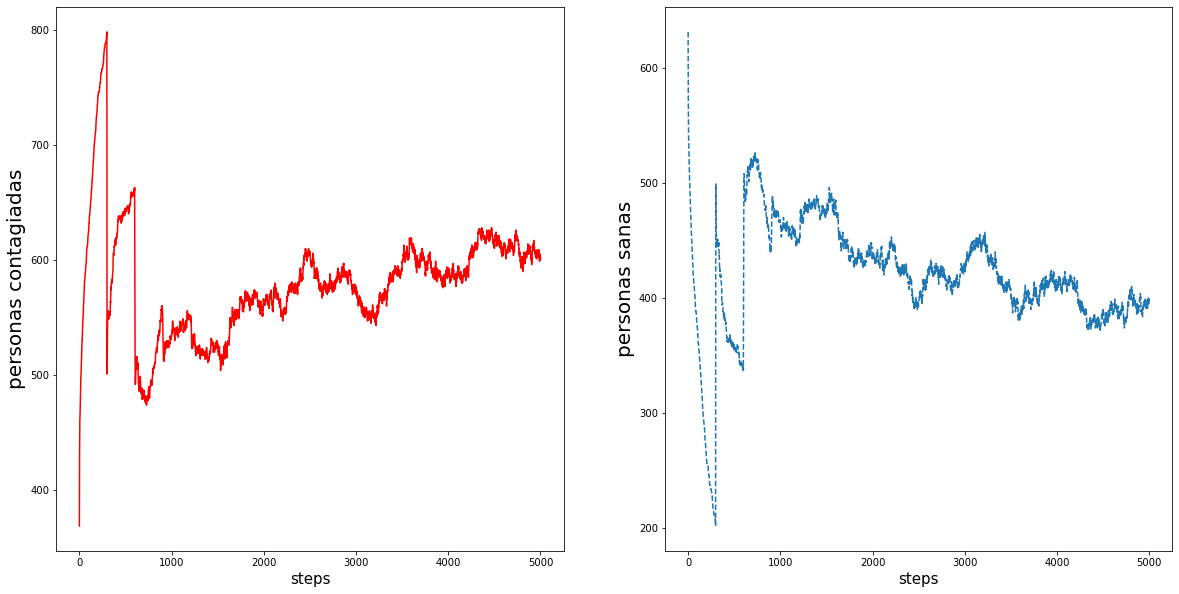

Random walk y gráficos guardados. Tardó 3726.7075946331024 segundos, 62.11179324388504 minutos


In [9]:
for p in set_de_parametros:
    print("Vamos con el set de parametros {0}".format(p))
    inicio = time.time()
    
    fig = plt.figure(figsize=(21, 10))
    ax = plt.axes(xlim=(0, RANGE*LONG_CELDA_EN_M), ylim=(0, RANGE*LONG_CELDA_EN_M)) 
    lines = gen_lines(ax, p['N_PERSONAS'])
    ax.set_xlabel('X', fontsize=18)
    ax.set_ylabel('Y', fontsize=18)
    ax.tick_params(labelsize=16)
    ax.grid(True, which='major', linestyle='--', color='black', alpha=0.4)


    ax.set_title('Simulación del contagio de una enfermedad', fontsize=22)
    tablero = Tablero(RANGE, p['N_PERSONAS'], PROBABILIDAD_DE_CONTAGIO,
                      p['λ'], p['α'], p['β'], p['N_CONTAGIOS'], p['T'])

    animar_por_enfermedad = True
    anim = animation.FuncAnimation(fig, animate_persons, fargs = (tablero, lines, animar_por_enfermedad),
                                   frames=STEPS, interval=295, blit=True)

    anim.save('videos/randomwalk_N={0}_alpha={1}_beta={2}_T={3}_lambda={4}.mp4'
                .format(p['N_PERSONAS'], p['α'], p['β'], p['T'], p['λ']))
    plt.close()
    t = time.time() - inicio
    
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    contagiados = tablero.get_personas_contagiadas()
    no_contagiados = [p['N_PERSONAS'] - n for n in contagiados]
    index = [i for i in range(len(contagiados))]
    #Plot izquierda
    axes[0].plot(index, contagiados, color='r')
    axes[0].set_xlabel('steps', fontsize=15) #Setea el nombre del eje x
    axes[0].set_ylabel('personas contagiadas', fontsize=20)

    #Plot derecha
    axes[1].plot(index, no_contagiados, linestyle="--")
    axes[1].set_xlabel('steps', fontsize=15) #Setea el nombre del eje x
    axes[1].set_ylabel('personas sanas', fontsize=20)

    plt.savefig('images/plot_N={0}_alpha={1}_beta={2}_T={3}_lambda={4}.png'
                .format(p['N_PERSONAS'], p['α'], p['β'], p['T'], p['λ']),
                dpi=300, bbox_inches='tight')
    plt.show()

print("Random walk y gráficos guardados. Tardó {0} segundos, {1} minutos".format(t, t/60))

# Conclusiones de las simulaciones

### Simulación 1
    {'N_PERSONAS': 1000, 'α': 250, 'β': 0.5, 'T': 2500, 'λ': 0.8, 'N_CONTAGIOS': True}
Podemos ver cómo la cantidad de contagios es muy alta a lo largo de toda la simulación. Este es un dato clave, porque la población puede enfermarse múltiples veces. Esto propone un panorama muy particular desde el punto de partida mismo. Podemos ver también cómo a partir del tiempo 2000 (cuando el gobierno adopta medidas) se reduce la cantidad de contagios y se aumenta la cantidad de personas sanas. Esto responde lógicamente a cómo se modelan las medidas: el gobierno dado un tiempo T garantiza que baje la probabilidad de contagio. Sería muy interesante ver cómo resultaría ese mismo trigger (adoptar medidas) en el mismo instante si la medida fuera algo más indirecta y real, por ejemplo, se minimiza la cantidad de gente que se mueve (nuestro parámetro lambda).

### Simulación 2
    {'N_PERSONAS': 1000, 'α': 250, 'β': 0.5, 'T': 750, 'λ': 0.8, 'N_CONTAGIOS': False}
En este caso nuestra enfermedad puede contagiar una única vez a la muestra poblacional. Por un lado, es lo más coherente desde el punto de vista epidemiológico (podríamos suponer), pero por el otro hace que nuestra simulación sea mucho menos rica por una cuestión de cantidad de gente: una vez que se contagió el total de las personas, dado un lapso de tiempo T lo suficientemente grande, todas estarán curadas y la enfermedad erradicada.
Es importante destacar en ésta ejecución

    1. como se mencionó recién, el contagio total se da muy pronto en la simulación y para el 1:12 de la misma, podemos ver cómo en unos pocos segundos la mayoría de las personas pasaron a estar sanas.
    2. la movilidad de la población es baja, y eso favorece la erradicación de la enfermedad.
    
Cabe destacar que se intentó aumentar considerablemente la cantidad de gente (a 5000) pero los tiempos de ejecuciones no lo permitieron.

### Simulación 3
    {'N_PERSONAS': 1000, 'α': 300, 'β': 0.7, 'T': 500, 'λ': 0.2, 'N_CONTAGIOS': True}
Para ésta última corrida, una vez más permitimos que las personas se contagien múltiples veces. Como hay poco movimiento, la curva de crecimiento de contagios (en los primeros segundos) es menos vertiginosa, pero aún así sigue siendo una pendiente muy alta ya que la densidad es alta en nuestra grilla.
La intervención estatal muy temprana en este contexto permite garantizar una baja sustanciosa de los contagios, y si bien luego de la caída abrupta se da un período extenso de crecimiento de contagios, se ve que el ritmo no es el mismo por las medidas adoptadas.

### Cómo seguir
Dado este punto se ve claramente que el modelo para el cual nuestras personas sólo pueden contagiarse una vez tiene una vida útil corta, mientras que si en nuestra simulación las personas pueden contagiarse N veces, entonces se aleja un poco de los contagios de enfermedades en la vida real dentro de una comunidad de gente.
Por lo tanto, se plantea como una extensión a incluir la posibilidad de tener gente "inmunizada" es decir, que dada una persona que ya se contagió, entonces un porcentaje pi no volverá a contagiarse mientras que otro porcentaje pi sí puede contagiarse nuevamente.